In [16]:
import numpy as np
import astropy
from astropy.io import ascii
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.table import Table
from matplotlib.colors import LogNorm
from astropy.table import join
import astropy.units as u
import all_fctns

def refresh_module():
    import importlib
    import all_fctns
    importlib.reload(all_fctns)


Source_dir ="C:\\Users\\mspan\\OneDrive - The University of Sydney (Students)\\Honours\\Honours Project\\"

SAMI_regions = ("Cluster", "Filler", "GAMA")
SAMI_Target_catalogues = ("InputCatClustersDR3.fits", "InputCatFiller.fits", "InputCatGAMADR3.fits")

crossmatching_catalogues = ("RACS-mid1_sources.fits", "LARGESS.fits", "eRASS1_Main.v1.1.fits")

# All SAMI

In [17]:
refresh_module()

all_fctns.get_all_SAMI_targets_catalogue(Source_dir+"Catalogues\\")

CATID,RA_OBJ,DEC_OBJ,r_petro,r_auto,z_spec,M_r,r_e,mu_within_1re,mu_1re,mu_2re,ellip,PA,g_i,Mstar,R_on_rtwo,V_on_sigma,is_mem,SURV_SAMI,BAD_CLASS,SAMI_region,FILLFLAG,RA_IFU,DEC_IFU,z_tonry,A_g
int64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,str8,int16,float64,float64,float32,float32
9011900001,14.0671544540651,-1.25536934215829,12.986222,13.169163,0.04452117,-23.33175,63.775894,22.915201,24.42576,25.986717,0.20853871,217.45499,1.3198166,11.5877,6.697878e-06,0.11110196,1,7,0,Clusters,--,--,--,--,--
9011900002,14.0740338479429,-1.26032983309023,16.286343,16.306042,0.03911899,-20.190361,1.387755,19.107248,20.176815,21.818083,0.072153755,275.84613,1.1202059,10.15713,0.01305153,-1.7402956,1,7,8,Clusters,--,--,--,--,--
9011900003,14.0745767980926,-1.26213395249889,15.871767,16.268087,0.03849665,-20.227768,nan,nan,nan,nan,nan,nan,1.1498327,10.205531,0.015452894,-1.9541932,1,7,0,Clusters,--,--,--,--,--
9011900005,14.0537852533633,-1.26329011523927,18.609417,17.308725,0.03778281,-19.185982,nan,nan,nan,nan,nan,nan,1.262867,9.887663,0.023897447,-2.199696,1,7,0,Clusters,--,--,--,--,--
9011900006,14.0756150589043,-1.24184017010364,15.212702,15.001332,0.04361263,-21.498928,2.6059005,19.021425,20.363825,21.946754,0.052937705,169.88126,1.2993641,10.841409,0.024552945,-0.19959885,1,7,0,Clusters,--,--,--,--,--
9011900007,14.0846572063946,-1.25063438254069,17.997269,18.026249,0.04105724,-18.47185,27.696348,24.935598,26.68287,28.223352,0.42923176,107.90984,1.1796379,9.530834,0.027897105,-1.0749329,1,7,0,Clusters,--,--,--,--,--
9011900008,14.0556512198554,-1.27001669208809,15.944301,15.723641,0.045318015,-20.778236,2.1965058,19.245888,20.680416,22.25035,0.099254526,232.4183,1.213438,10.474614,0.028646763,0.38338172,1,7,8,Clusters,--,--,--,--,--
9011900009,14.0534865822132,-1.26942390078162,15.902063,15.652073,0.045034066,-20.849602,2.5547311,19.301964,20.665499,22.245218,0.29823938,223.73413,1.2527571,10.533861,0.030153474,0.28638074,1,7,0,Clusters,--,--,--,--,--
9011900011,14.055867985949,-1.23839880327462,16.880154,16.626684,0.048625406,-19.87669,9.380324,22.387285,23.869879,25.433975,0.41189596,134.14691,1.1027069,10.014269,0.03135175,1.511288,1,7,0,Clusters,--,--,--,--,--


# Getting cutouts

In [18]:
# testing a cutout of 09h Gamma Region

input_files = ["RACS-mid1_components.fits", "RACS-mid1_sources.fits"]
input_files1 = "RACS-mid1_components.fits"



In [19]:
""" Used to test the circular cutout function
"""
input_files = ["RACS-mid1_components.fits", "RACS-mid1_sources.fits"]
input_files1 = "RACS-mid1_components.fits"

GAMA_region_bounds = [((129,-2), (141, 3)), ((174, -3), (186, 2)), ((211.5, -2), (223.5, 3))] # bounds of the GAMA target regions in the SAMI data including filler which are rectangular in shape (bottom left to top right coords) all in degrees

Cluster_region_bounds = [((355.397880, -29.236351), 2), ((18.815777, 0.213486), 1.5), ((18.739974, 0.430807), 1), 
                         ((356.937810, -28.140661), 3), ((6.380680, -33.046570), 1.5), ((336.977050, -30.575371), 2), 
                         ((329.372605, -7.795692), 2), ((14.067150, -1.255370), 2), ((10.460211, -9.303184), 3)] # bounds of the Cluster target regions (including filler targets) circular in shape  ((x_centre,y_centre), r_approx) all in degrees




with fits.open(Source_dir+"Catalogues\\"+input_files1) as hdul:
    #del hdul[0]

    hdul.info()
    table_hdu = Table(hdul[1].data)

    bound_type = 'circ'
    cutout_tables = []
    
    bounds = ((355.397880, -29.236351), 2.0)
    table_hdu_both_cutout = all_fctns.get_RA_Dec_cutout_fits_table(table_hdu, bounds, bound_type=bound_type)

i=0
while True:
    try:
        table_hdu_both_cutout.write(Source_dir+f"Catalogues\\test_cluster_{i:02}_"+input_files1)
        break
    except OSError:
        i+=1
        

Filename: C:\Users\mspan\OneDrive - The University of Sydney (Students)\Honours\Honours Project\Catalogues\RACS-mid1_components.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (8797,)   uint8   
  1  RACS-mid1_components.xml    1 BinTableHDU    215   4199578R x 42C   [18A, 17A, 12A, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, A, K, D, D, K, D]   


## Cross-matching

In [20]:
cutout_prefix = "SAMI_target_region_cutout_"
SAMI_Target_catalogues = ("InputCatClustersDR3.fits", "InputCatFiller.fits", "InputCatGAMADR3.fits")

def get_crossmatched_fits_table(catalogue_filepath, 
                                SAMI_target_table, 
                                survey_cutout_table_hdu, 
                                sep_arcsec = 20, 
                                crossmatching_colnames = ('RA', 'Dec'), 
                                save_file = False, 
                                cat_names = ('All_SAMI', 'RACS-mid1_sources'),
                                only_closest = False,
                                SAMI_cols_to_keep = ('CATID', 'RA_OBJ', 'DEC_OBJ'),
                                survey_cols_to_keep = 'ALL'):
    """
    Returns and Saves a crossmatched catalogue of a SAMI_Target_catalogue and the desired crossmatching_catalogue when separation of objects is less than sep_arcsec.
    """

    max_separation = sep_arcsec*u.arcsec #max distance to be considered a match in arcsec

    SAMI_RA_array = np.array(SAMI_target_table['RA_OBJ'])
    SAMI_Dec_array = np.array(SAMI_target_table['DEC_OBJ'])

    SAMI_coords = SkyCoord(SAMI_RA_array, SAMI_Dec_array, unit='deg')
    
    survey_cutout_RA_array = np.array(survey_cutout_table_hdu[crossmatching_colnames[0]])
    survey_cutout_Dec_array = np.array(survey_cutout_table_hdu[crossmatching_colnames[1]])

    survey_cutout_coords = SkyCoord(survey_cutout_RA_array, survey_cutout_Dec_array, unit='deg')


    # initialise reduced version of SAMI default is keeping only CATID, RA_OBJ and DEC_OBJ columns
    reduced_SAMI_target_table = SAMI_target_table.copy()    
    if not SAMI_cols_to_keep == 'ALL':
        reduced_SAMI_target_table.keep_columns(SAMI_cols_to_keep)

    # now initialise a reduced version of the matching catalogue default is to keep all columns
    reduced_survey_cutout_table_hdu = survey_cutout_table_hdu.copy()
    if not survey_cols_to_keep == 'ALL':
        reduced_survey_cutout_table_hdu.keep_columns(survey_cols_to_keep)


    # now, do crossmatching with Skycoord
    matched_indices, separation, _ = SAMI_coords.match_to_catalog_sky(survey_cutout_coords)
    
    
    survey_cutout_matched_table = reduced_survey_cutout_table_hdu[matched_indices]

    crossmatched_table = astropy.table.hstack([reduced_SAMI_target_table, survey_cutout_matched_table, Table([separation.arcsec], names=['sep_arcsec'])])
    reduced_crossmatched_table = crossmatched_table[crossmatched_table['sep_arcsec']*u.arcsec<=max_separation]

    # ensure only closest match is kept in table
    if only_closest:
        sorted_reduced_crossmatched_table = reduced_crossmatched_table[reduced_crossmatched_table.argsort('sep_arcsec')]
        sep_sorted_survey_RA = sorted_reduced_crossmatched_table[crossmatching_colnames[0]]
        unique_sep_sorted_survey_RA, unique_index = np.unique(sep_sorted_survey_RA, return_index = True)

        reduced_crossmatched_table= sorted_reduced_crossmatched_table[unique_index]



    if save_file:
        crossmatched_filename = f"{cat_names[0]}_matched_{cat_names[1]}.fits"

        crossmatched_filepath = catalogue_filepath+"Crossmatched\\"+crossmatched_filename
        reduced_crossmatched_table.write(crossmatched_filepath)
        print(f"Crossmatched Table Saved to: {crossmatched_filepath}")

    return reduced_crossmatched_table

def get_all_SAMI_crossmatched_fits_table(catalogue_filepath, 
                                crossmatching_catalogue, 
                                sep_arcsec = 20, 
                                crossmatching_colnames = ('RA', 'Dec'), 
                                separation_column = True, 
                                save_file = False, 
                                only_closest = True,
                                SAMI_cols_to_keep = ('CATID', 'RA_OBJ', 'DEC_OBJ'),
                                survey_cols_to_keep = 'ALL'):
    
    SAMI_Target_catalogues = ("InputCatClustersDR3.fits", "InputCatFiller.fits", "InputCatGAMADR3.fits")
    SAMI_regions = ("Clusters", "Filler", "GAMA")


    # test if the combined SAMI target catalogue exists
    try: 
        with fits.open(catalogue_filepath + "ALL_SAMI_TARGETS.fits") as all_SAMI_targets_hdul:
            None
    except FileNotFoundError: # if not, produce one
        print("All SAMI Targets Catalogue does not already exist.")
        all_fctns.get_all_SAMI_targets_catalogue(catalogue_filepath)


    # test if a cutout of the survey exists
    try:
        with fits.open(catalogue_filepath + "SAMI_target_region_cutout_" + crossmatching_catalogue) as survey_cutout_hdul:
            None
    except FileNotFoundError: # if not, produce one
        print("SAMI Target Region Cutout does not already exist.")
        all_fctns.get_fits_table_SAMI_target_regions_cutout(catalogue_filepath, crossmatching_catalogue, col_names=crossmatching_colnames)

    with fits.open(catalogue_filepath + "ALL_SAMI_TARGETS.fits") as all_SAMI_targets_hdul, fits.open(catalogue_filepath + "SAMI_target_region_cutout_" + crossmatching_catalogue) as survey_cutout_hdul:
        all_SAMI_target_table = Table(all_SAMI_targets_hdul[1].data)
        survey_cutout_table_hdu = Table(survey_cutout_hdul[1].data)

    all_SAMI_crossmatched_table = get_crossmatched_fits_table(catalogue_filepath, 
                                                        all_SAMI_target_table, 
                                                        survey_cutout_table_hdu, 
                                                        save_file=False, 
                                                        sep_arcsec=sep_arcsec,
                                                        only_closest = only_closest,
                                                        crossmatching_colnames=crossmatching_colnames, 
                                                        SAMI_cols_to_keep = SAMI_cols_to_keep,
                                                        survey_cols_to_keep = survey_cols_to_keep)

    if save_file:
        crossmatched_filename = f"all_SAMI_target_matched_{crossmatching_catalogue}"

        crossmatched_filepath = catalogue_filepath+"Crossmatched\\"+crossmatched_filename
        all_SAMI_crossmatched_table.write(crossmatched_filepath)
        print(f"Crossmatched Table Saved to: {crossmatched_filepath}")


    return all_SAMI_crossmatched_table



In [21]:
cutout_prefix = "SAMI_target_region_cutout_"
SAMI_Target_catalogues = ("InputCatClustersDR3.fits", "InputCatFiller.fits", "InputCatGAMADR3.fits")


## RACS

In [22]:
fits_filename = "RACS-mid1_sources.fits"
fits_filepath = Source_dir+"Catalogues\\"

RACS_crossmatch = get_all_SAMI_crossmatched_fits_table(fits_filepath, fits_filename, sep_arcsec=20, save_file=False)
RACS_crossmatch

CATID,RA_OBJ,DEC_OBJ,Name,Source_ID,Field_ID,RA,Dec,Dec_corr,E_RA,E_Dec,E_Dec_corr,Total_flux,E_Total_flux_PyBDSF,E_Total_flux,Peak_flux,E_Peak_flux_PyBDSF,E_Peak_flux,Maj_axis,Min_axis,PA,E_Maj_axis,E_Min_axis,E_PA,DC_Maj_axis,DC_Min_axis,DC_PA,E_DC_Maj_axis,E_DC_Min_axis,E_DC_PA,Noise,Tile_l,Tile_m,Tile_sep,Gal_lon,Gal_lat,PSF_Maj,PSF_Min,PSF_PA,S_Code,N_Gaussians,Flag,Scan_start_MJD,Scan_length,SBID,E_Flux_scale,sep_arcsec
int64,float64,float64,str26,str17,str12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str1,int64,int64,float64,float64,int64,float64,float64
9044200999,5.4792542,-33.2804985,RACS-MID1 J002155.0-331652,RACS_0012-32_965,RACS_0012-32,5.47900803530835,-33.281133244061415,-33.28122791606581,0.00026491637189614894,9.318664790956359e-05,0.00019711227585383082,5.730683009979624,0.8733516607890479,0.9385998845845428,2.5226104078022447,0.16938238695729524,0.22715461866697503,24.534151339311087,9.412175504215686,14.679258111882262,2.3316553633217176,0.48064053837139786,4.8535714090969355,22.725820143271726,0.0,15.317286179674966,2.3316553633217176,0.48064053837139786,4.8535714090969355,0.16938238695729524,1.9858186020716326,-0.6918388951696569,2.102882920469552,347.1554207284717,-81.14283343535149,11.400000000000002,9.199999999999998,113.89,M,4,1,59220.41381163114,905.7484803479,20910,0.06,2.4021744621564007
9044200147,6.1329665,-33.0879364,RACS-MID1 J002431.9-330517,RACS_0012-32_635,RACS_0012-32,6.133001860025605,-33.08793478700892,-33.08802972611498,7.113750301105086e-05,0.00010163093060513312,0.0002001956735483823,3.6918560313828293,0.3412918029853741,0.40687513837571276,2.6439658901187815,0.15592309616048303,0.22243653516783837,13.529882354882407,10.834497134216038,164.55105275862735,0.8759407796655455,0.5820192259576282,10.473473082329203,0.0,0.0,0.0,0.8759407796655455,0.5820192259576282,10.473473082329203,0.1477858459111303,2.5379452414160997,-0.5126422624303635,2.5892022203095015,345.6023369651445,-81.67493223290087,11.400000000000002,9.199999999999998,113.89,S,1,1,59220.41381163114,905.7484803479,20910,0.06,0.10681091334619837
9044200061,6.2697597,-33.1035461,RACS-MID1 J002504.7-330613,RACS_0037-32_3575,RACS_0037-32,6.269477141718634,-33.103512517162414,-33.10360743496323,0.00011244329592705006,8.421350356478395e-05,0.00019202882082522293,2.4496315850119195,0.3164511511360706,0.34891808881681813,2.3633410113773707,0.17594891451923933,0.2259765279189592,12.092203524234838,8.999546172369174,120.53713523889941,1.03939199421943,0.5803192807754185,13.417311725457681,4.131040115563642,0.0,130.9979184613339,1.03939199421943,0.5803192807754185,13.417311725457681,0.17726997612044215,-2.5469664940623584,-0.5284904239067278,2.601219031538298,344.97117720302526,-81.74588527440379,11.400000000000002,9.199999999999998,113.91,S,1,0,59220.42763563113,895.795199898987,20911,0.06,0.8606354106671932
9044200188,6.5992751,-33.2288246,RACS-MID1 J002623.8-331344,RACS_0012-32_425,RACS_0012-32,6.599110116586952,-33.228794282830755,-33.22888902781148,0.00025960216747298616,0.00024130869370301978,0.00029712812670149214,0.9550373550267699,0.311832007171521,0.31705322511339795,0.8526528779597434,0.16676826227016894,0.1744388553323679,11.07137418131985,10.62447905135479,99.67801894561656,2.2046374093712444,2.041052365496089,178.1188112578546,0.0,0.0,0.0,2.2046374093712444,2.041052365496089,178.1188112578546,0.1625472796149552,2.923605350873934,-0.6655255589213802,2.9983983253123867,342.9733359964949,-81.8488241279283,11.400000000000002,9.199999999999998,113.89,S,1,0,59220.41381163114,905.7484803479,20910,0.06,0.5086712744012896
9044200305,6.7954707,-32.8635597,RACS-MID1 J002710.9-325148,RACS_0037-32_3323,RACS_0037-32,6.795359023608419,-32.86345558998069,-32.86355083159545,2.829412675051292e-05,2.6024822807276082e-05,0.00017

In [23]:
a = RACS_crossmatch[RACS_crossmatch['CATID']==9403801368]
print(np.sum(a['Total_flux']))

RACS_crossmatch[RACS_crossmatch['CATID']==9403801368]

94.02077048564108


CATID,RA_OBJ,DEC_OBJ,Name,Source_ID,Field_ID,RA,Dec,Dec_corr,E_RA,E_Dec,E_Dec_corr,Total_flux,E_Total_flux_PyBDSF,E_Total_flux,Peak_flux,E_Peak_flux_PyBDSF,E_Peak_flux,Maj_axis,Min_axis,PA,E_Maj_axis,E_Min_axis,E_PA,DC_Maj_axis,DC_Min_axis,DC_PA,E_DC_Maj_axis,E_DC_Min_axis,E_DC_PA,Noise,Tile_l,Tile_m,Tile_sep,Gal_lon,Gal_lat,PSF_Maj,PSF_Min,PSF_PA,S_Code,N_Gaussians,Flag,Scan_start_MJD,Scan_length,SBID,E_Flux_scale,sep_arcsec
int64,float64,float64,str26,str17,str12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str1,int64,int64,float64,float64,int64,float64,float64
9403801368,357.9030151,-28.3649693,RACS-MID1 J235136.6-282154,RACS_2348-28_1710,RACS_2348-28,357.90234899096237,-28.364950978312137,-28.365050505690203,7.339006879748627e-06,1.431302392922859e-05,0.00014512591418137263,94.02077048564108,1.8625087703595764,5.940757353859464,50.98023405927225,0.2302966604474932,3.0674712557529733,22.309063022499398,12.670360053184208,72.4700568503202,0.1259439008673649,0.052263180995365775,0.493419276294676,19.673455565551173,7.397051093156059,68.76901163042683,0.1259439008673649,0.052263180995365775,0.493419276294676,0.2302966604474932,0.7940113811167082,-0.3983961413048533,0.8883544105529652,24.127314914171098,-76.71369151599194,11.400000000000002,9.299999999999999,112.85,M,4,1,59210.42334123114,895.795199898987,20418,0.06,2.111118450767832


## LARGESS

In [24]:
# converting LARGESS data from .dat to .fits 
 # initially converted the .dat and saved as a .txt file
# https://cdsarc.cds.unistra.fr/ftp/J/MNRAS/464/1306/ReadMe

save_LARGESS=False
if save_LARGESS:
    LARGESS_data = ascii.read(Source_dir+"Catalogues\\LARGESS.txt")

    LARGESS_labels = ('Name', 'SDSS', "RAdeg", "DEdeg", "rmag", "e_rmag", "imod", "e_imod", "gmod", "e_gmod", "NFIRST", "FFIRST", 
                    "NNVSS", "FNVSS", "z", "q_z", "zsource", "OIII-SN", "EWOIII", "VClass", "BClass", "HIcomp", "f_z", "DisGAMA")



    for i, colname in enumerate(LARGESS_labels):
        LARGESS_data.rename_column(f"col{i+1}", colname)
    LARGESS_data

    LARGESS_savepath = Source_dir+"Catalogues\\LARGESS.fits"
    LARGESS_data.write(LARGESS_savepath)

In [25]:
fits_filename = "LARGESS.fits"
fits_filepath = Source_dir+"Catalogues\\"

get_all_SAMI_crossmatched_fits_table(fits_filepath, fits_filename, sep_arcsec=20, crossmatching_colnames=("RAdeg", "DEdeg"))

CATID,RA_OBJ,DEC_OBJ,Name,SDSS,RAdeg,DEdeg,rmag,e_rmag,imod,e_imod,gmod,e_gmod,NFIRST,FFIRST,NNVSS,FNVSS,z,q_z,zsource,OIII-SN,EWOIII,VClass,BClass,HIcomp,f_z,DisGAMA,sep_arcsec
int64,float64,float64,str19,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,float64,int64,str9,str6,str7,str7,str7,int64,int64,int64,float64
9011901004,13.4276619272992,-1.0851857429077,J005342.63-010506.5,588015507664601175,13.42765,-1.08516,14.799,0.043,14.41,0.003,15.65,0.004,1,3.48,1,2.7,0.04655,4,SDSS,188.00,22.20,NA,HERG,1,-1,-1,0.1021351620271435
9011900413,13.9772544060016,-0.920661600578013,J005554.54-005514.3,587731185136304141,13.97726,-0.92065,14.136,0.023,13.544,0.002,14.906,0.003,1,1.91,0,-99.0,0.04498,5,SDSS,4.36,0.49,NA,LERG,1,-1,-1,0.046362933637400856
9011900547,14.2585403462785,-0.875188276838173,J005702.04-005230.7,587731185136435215,14.25854,-0.87519,13.56,0.01,12.994,0.002,14.277,0.002,3,72.48,3,107.7,0.04416,5,SDSS,6.72,0.68,NA,LERG,1,-1,-1,0.006327369980997971
9011901426,14.3650945311976,-0.471593857820377,J005727.62-002817.6,587731185673306247,14.36509,-0.47158,14.266,0.02,13.717,0.002,15.076,0.003,1,4.99,1,5.8,0.04391,5,SDSS,3.41,0.46,NA,LERG,1,-1,-1,0.05248715386960684
9016800216,18.6244003524325,0.215201723726597,J011429.85+001254.7,587731513142542498,18.62441,0.2152,15.817,0.024,15.371,0.003,16.611,0.004,1,1.29,0,-99.0,0.04629,5,SDSS,34.90,8.04,NA,SF,1,-1,-1,0.03528100634282422
9016800093,18.6827575975227,0.286029828924826,J011443.86+001709.6,587731513142608083,18.68276,0.28601,15.34,0.005,14.957,0.003,16.006,0.004,1,0.5,1,2.9,0.04522,5,SDSS,7.52,1.60,NA,SF,1,-1,-1,0.07190616002631368
9016800318,18.7344378723916,0.130685816704439,J011456.26+000750.4,588015509277573202,18.73444,0.13068,14.84,0.003,14.249,0.003,15.37,0.003,1,1.65,1,2.1,0.04153,5,SDSS,5.42,0.62,NA,SF,1,-1,-1,0.022296978462671507
9016800001,18.739974118087,0.430806769669402,J011457.59+002550.9,588015509814444216,18.73996,0.43081,13.649,0.005,13.084,0.002,14.364,0.002,1,3.13,1,4.1,0.04479,5,SDSS,3.13,0.47,NA,LERG,1,-1,-1,0.05213716674419315
9016800167,18.7842644101088,0.227090606952086,J011508.22+001337.5,587731513142673601,18.78425,0.2271,15.879,0.008,15.22,0.004,16.332,0.004,1,0.96,0,-99.0,0.04372,5,SDSS,9.43,1.40,NA,SF,1,-1,-1,0.06192390573131619


## eROSITA

In [26]:
fits_filename = "eRASS1_Main.v1.1.fits"
fits_filepath = Source_dir+"Catalogues\\"

with fits.open(fits_filepath + fits_filename) as eROSITA_hdul:
    eROSITA_hdul.info



get_all_SAMI_crossmatched_fits_table(fits_filepath, fits_filename, sep_arcsec=40, crossmatching_colnames=("RA", "DEC"))

CATID,RA_OBJ,DEC_OBJ,IAUNAME,DETUID,SKYTILE,ID_SRC,UID,UID_Hard,ID_CLUSTER,RA,DEC,RA_RAW,DEC_RAW,RA_LOWERR,RA_UPERR,DEC_LOWERR,DEC_UPERR,POS_ERR,RADEC_ERR,LII,BII,ELON,ELAT,MJD,MJD_MIN,MJD_MAX,EXT,EXT_ERR,EXT_LOWERR,EXT_UPERR,EXT_LIKE,DET_LIKE_0,ML_CTS_1,ML_CTS_ERR_1,ML_CTS_LOWERR_1,ML_CTS_UPERR_1,ML_RATE_1,ML_RATE_ERR_1,ML_RATE_LOWERR_1,ML_RATE_UPERR_1,ML_FLUX_1,ML_FLUX_ERR_1,ML_FLUX_LOWERR_1,ML_FLUX_UPERR_1,ML_BKG_1,ML_EXP_1,ML_EEF_1,APE_CTS_1,APE_BKG_1,APE_EXP_1,APE_RADIUS_1,APE_POIS_1,DET_LIKE_P1,ML_CTS_P1,ML_CTS_ERR_P1,ML_CTS_LOWERR_P1,ML_CTS_UPERR_P1,ML_RATE_P1,ML_RATE_ERR_P1,ML_RATE_LOWERR_P1,ML_RATE_UPERR_P1,ML_FLUX_P1,ML_FLUX_ERR_P1,ML_FLUX_LOWERR_P1,ML_FLUX_UPERR_P1,ML_BKG_P1,ML_EXP_P1,ML_EEF_P1,APE_CTS_P1,APE_BKG_P1,APE_EXP_P1,APE_RADIUS_P1,APE_POIS_P1,DET_LIKE_P2,ML_CTS_P2,ML_CTS_ERR_P2,ML_CTS_LOWERR_P2,ML_CTS_UPERR_P2,ML_RATE_P2,ML_RATE_ERR_P2,ML_RATE_LOWERR_P2,ML_RATE_UPERR_P2,ML_FLUX_P2,ML_FLUX_ERR_P2,ML_FLUX_LOWERR_P2,ML_FLUX_UPERR_P2,ML_BKG_P2,ML_EXP_P2,ML_EEF_P2,APE_CTS_P2,APE_BKG_P2,APE_EXP_P2,APE_RADIUS_P2,APE_POIS_P2,DET_LIKE_P3,ML_CTS_P3,ML_CTS_ERR_P3,ML_CTS_LOWERR_P3,ML_CTS_UPERR_P3,ML_RATE_P3,ML_RATE_ERR_P3,ML_RATE_LOWERR_P3,ML_RATE_UPERR_P3,ML_FLUX_P3,ML_FLUX_ERR_P3,ML_FLUX_LOWERR_P3,ML_FLUX_UPERR_P3,ML_BKG_P3,ML_EXP_P3,ML_EEF_P3,APE_CTS_P3,APE_BKG_P3,APE_EXP_P3,APE_RADIUS_P3,APE_POIS_P3,DET_LIKE_P4,ML_CTS_P4,ML_CTS_ERR_P4,ML_CTS_LOWERR_P4,ML_CTS_UPERR_P4,ML_RATE_P4,ML_RATE_ERR_P4,ML_RATE_LOWERR_P4,ML_RATE_UPERR_P4,ML_FLUX_P4,ML_FLUX_ERR_P4,ML_FLUX_LOWERR_P4,ML_FLUX_UPERR_P4,ML_BKG_P4,ML_EXP_P4,ML_EEF_P4,APE_CTS_P4,APE_BKG_P4,APE_EXP_P4,APE_RADIUS_P4,APE_POIS_P4,DET_LIKE_P5,ML_CTS_P5,ML_CTS_ERR_P5,ML_CTS_LOWERR_P5,ML_CTS_UPERR_P5,ML_RATE_P5,ML_RATE_ERR_P5,ML_RATE_LOWERR_P5,ML_RATE_UPERR_P5,ML_FLUX_P5,ML_FLUX_ERR_P5,ML_FLUX_LOWERR_P5,ML_FLUX_UPERR_P5,ML_BKG_P5,ML_EXP_P5,ML_EEF_P5,APE_CTS_P5,APE_BKG_P5,APE_EXP_P5,APE_RADIUS_P5,APE_POIS_P5,DET_LIKE_P6,ML_CTS_P6,ML_CTS_ERR_P6,ML_CTS_LOWERR_P6,ML_CTS_UPERR_P6,ML_RATE_P6,ML_RATE_ERR_P6,ML_RATE_LOWERR_P6,ML_RATE_UPERR_P6,ML_FLUX_P6,ML_FLUX_ERR_P6,ML_FLUX_LOWERR_P6,ML_FLUX_UPERR_P6,ML_BKG_P6,ML_EXP_P6,ML_EEF_P6,APE_CTS_P6,APE_BKG_P6,APE_EXP_P6,APE_RADIUS_P6,APE_POIS_P6,DET_LIKE_P7,ML_CTS_P7,ML_CTS_ERR_P7,ML_CTS_LOWERR_P7,ML_CTS_UPERR_P7,ML_RATE_P7,ML_RATE_ERR_P7,ML_RATE_LOWERR_P7,ML_RATE_UPERR_P7,ML_FLUX_P7,ML_FLUX_ERR_P7,ML_FLUX_LOWERR_P7,ML_FLUX_UPERR_P7,ML_BKG_P7,ML_EXP_P7,ML_EEF_P7,APE_CTS_P7,APE_BKG_P7,APE_EXP_P7,APE_RADIUS_P7,APE_POIS_P7,DET_LIKE_P8,ML_CTS_P8,ML_CTS_ERR_P8,ML_CTS_LOWERR_P8,ML_CTS_UPERR_P8,ML_RATE_P8,ML_RATE_ERR_P8,ML_RATE_LOWERR_P8,ML_RATE_UPERR_P8,ML_FLUX_P8,ML_FLUX_ERR_P8,ML_FLUX_LOWERR_P8,ML_FLUX_UPERR_P8,ML_BKG_P8,ML_EXP_P8,ML_EEF_P8,APE_CTS_P8,APE_BKG_P8,APE_EXP_P8,APE_RADIUS_P8,APE_POIS_P8,DET_LIKE_P9,ML_CTS_P9,ML_CTS_ERR_P9,ML_CTS_LOWERR_P9,ML_CTS_UPERR_P9,ML_RATE_P9,ML_RATE_ERR_P9,ML_RATE_LOWERR_P9,ML_RATE_UPERR_P9,ML_FLUX_P9,ML_FLUX_ERR_P9,ML_FLUX_LOWERR_P9,ML_FLUX_UPERR_P9,ML_BKG_P9,ML_EXP_P9,ML_EEF_P9,APE_CTS_P9,APE_BKG_P9,APE_EXP_P9,APE_RADIUS_P9,APE_POIS_P9,APE_CTS_S,APE_BKG_S,APE_EXP_S,APE_POIS_S,FLAG_SP_SNR,FLAG_SP_BPS,FLAG_SP_SCL,FLAG_SP_LGA,FLAG_SP_GC_CONS,FLAG_NO_RADEC_ERR,FLAG_NO_EXT_ERR,FLAG_NO_CTS_ERR,FLAG_OPT,sep_arcsec
int64,float64,float64,str23,str32,int32,int32,int64,int64,int32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,f

# PLOTS:

### Separation histograms

C:\Users\mspan\AppData\Local\Temp\ipykernel_12084\3322742826.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


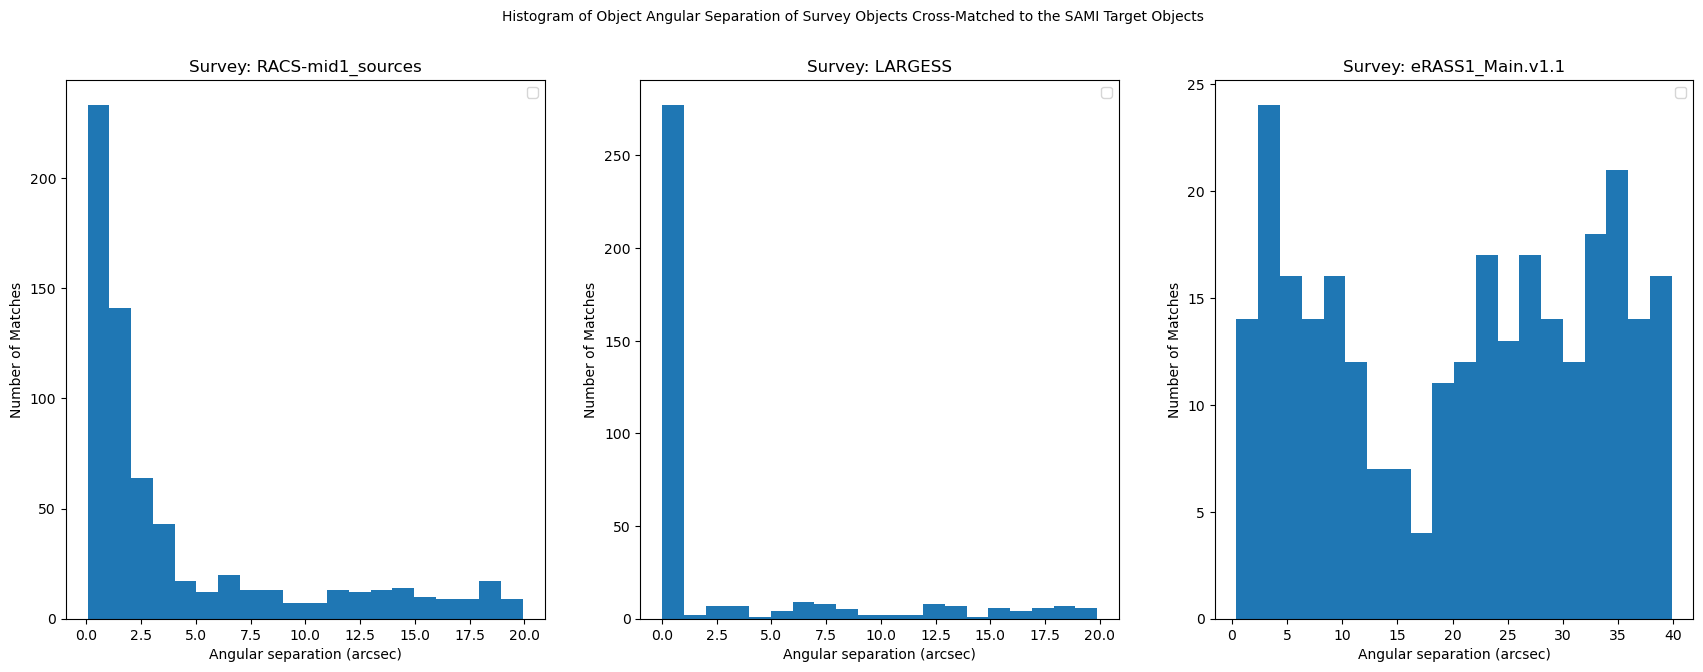

In [27]:
""" Looking at speration of cross-matches to determine where appropriate cutoff should be
"""

crossmatching_catalogue = crossmatching_catalogues[0]
fits_filepath = Source_dir+"Catalogues\\"


height, width = 7, 21
fig1, axs1 = plt.subplots(1, 3)
fig1.set_figheight(height)
fig1.set_figwidth(width)
fig1.suptitle(f'Histogram of Object Angular Separation of Survey Objects Cross-Matched to the SAMI Target Objects', fontsize=10)


for i, crossmatching_catalogue in enumerate(crossmatching_catalogues):
    crossmatched_filename = f"all_SAMI_target_matched_{crossmatching_catalogue}"
    crossmatched_filepath = fits_filepath+"Crossmatched\\"+crossmatched_filename

    with fits.open(crossmatched_filepath) as crossmatched_hdul:
        crossmatched_table_hdu = Table(crossmatched_hdul[1].data)

        separation_array = np.array(crossmatched_table_hdu['separation'])
        region_ls = crossmatched_table_hdu['SAMI_region']

    
    ax = axs1.flatten()[i]
    nbins = 20
    ax.hist(separation_array, bins = nbins)
    ax.set_title(f"Survey: {crossmatching_catalogue[:-5]}")
    ax.legend()
    ax.set_xlabel('Angular separation (arcsec)')
    ax.set_ylabel('Number of Matches')


#crossmatched_table_hdu


C:\Users\mspan\AppData\Local\Temp\ipykernel_12084\3266083820.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


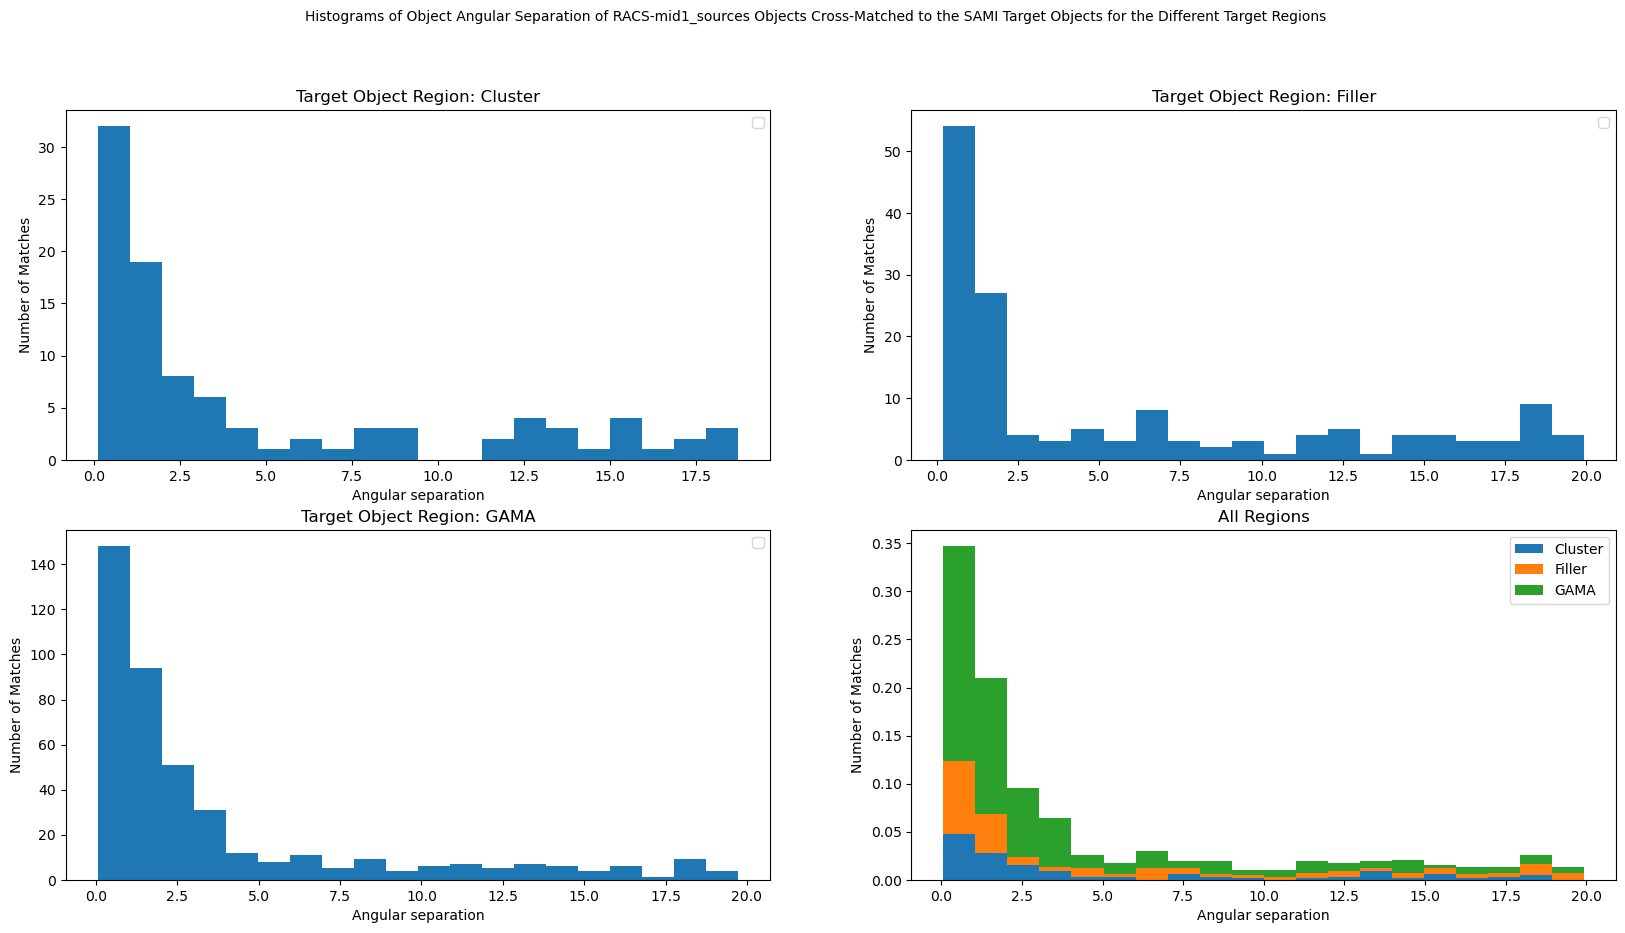

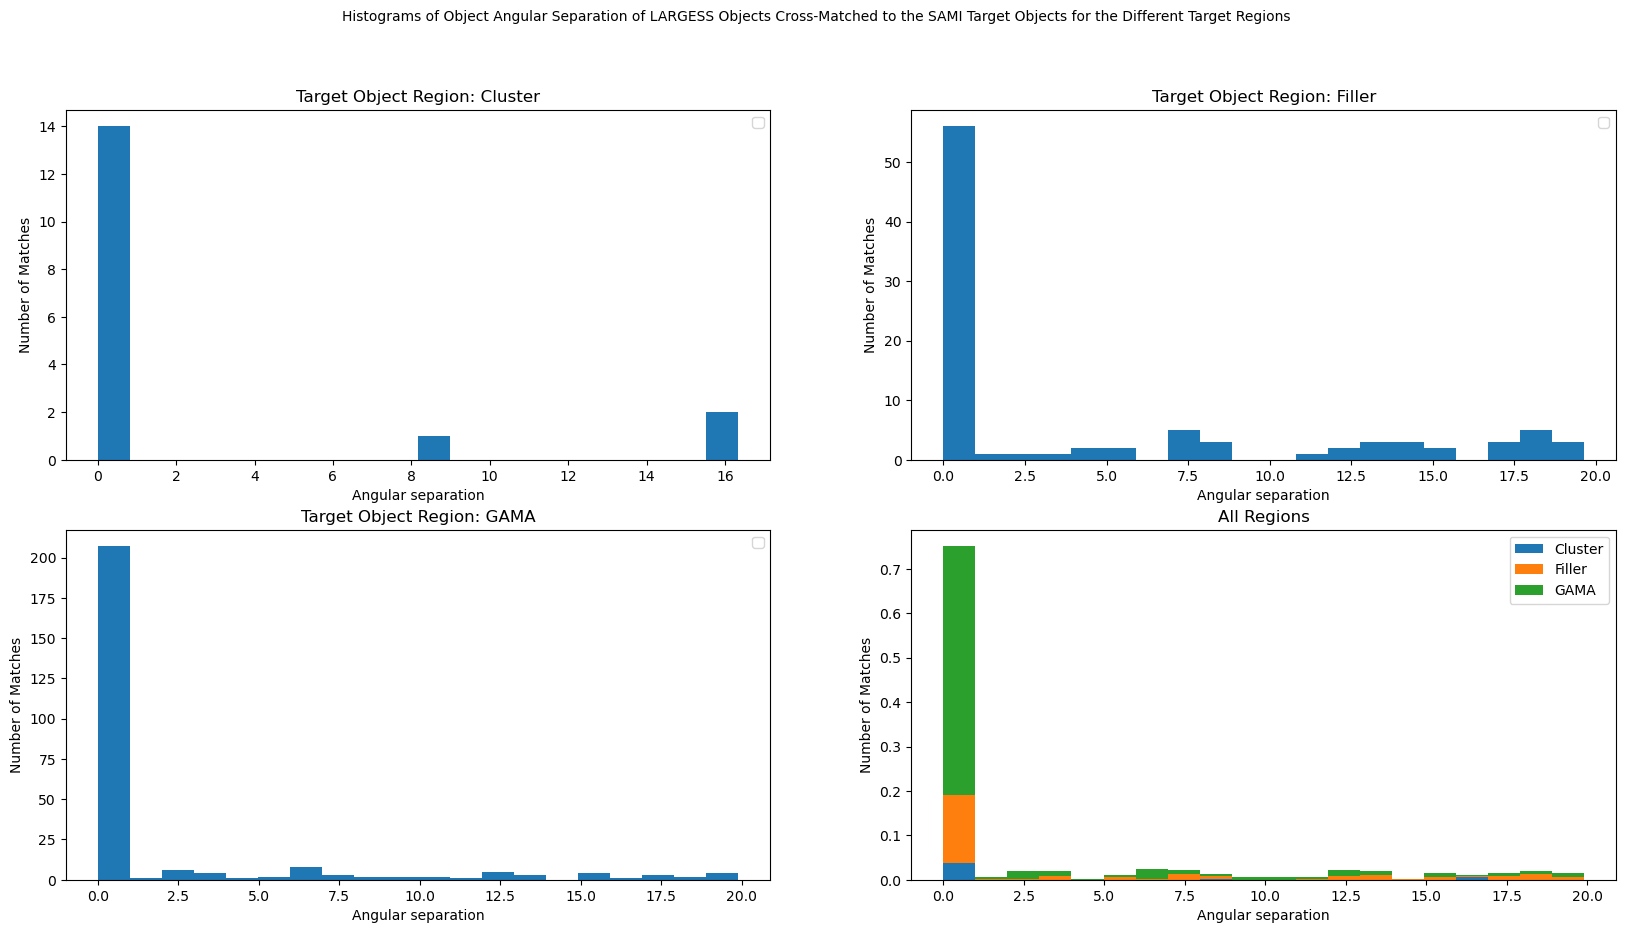

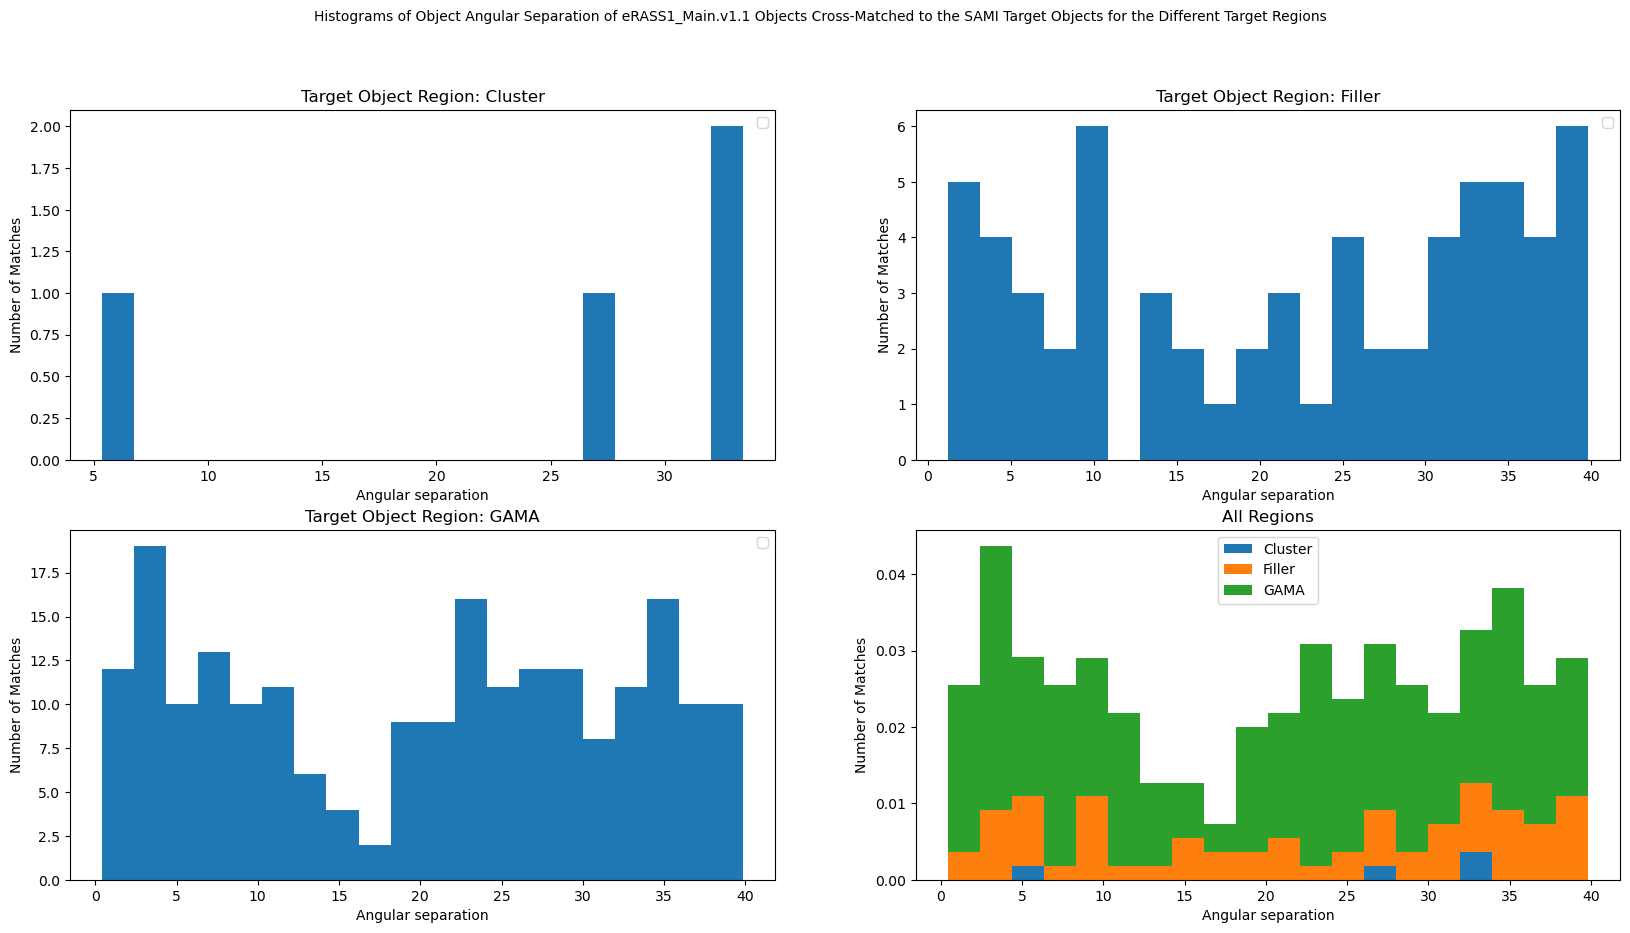

In [28]:
""" Looking at region by region
"""






for i, crossmatching_catalogue in enumerate(crossmatching_catalogues):    
    height, width = 10, 20
    fig1, axs1 = plt.subplots(2, 2)
    fig1.set_figheight(height)
    fig1.set_figwidth(width)
    fig1.suptitle(f'Histograms of Object Angular Separation of {crossmatching_catalogue[:-5]} Objects Cross-Matched to the SAMI Target Objects for the Different Target Regions', fontsize=10)

    crossmatched_filename = f"all_SAMI_target_matched_{crossmatching_catalogue}"
    crossmatched_filepath = fits_filepath+"Crossmatched\\"+crossmatched_filename

    with fits.open(crossmatched_filepath) as crossmatched_hdul:
        crossmatched_table_hdu = Table(crossmatched_hdul[1].data)

        separation_array = np.array(crossmatched_table_hdu['separation'])
        region_ls = crossmatched_table_hdu['SAMI_region']
        sep_regions = [0,0,0]

    for j, region in enumerate(SAMI_regions):    
        region_separation_array = separation_array[region_ls==region]

        sep_regions[j] = region_separation_array

        ax = axs1.flatten()[j]
        nbins = 20
        ax.hist(region_separation_array, bins = nbins)
        ax.set_title(f"Target Object Region: {region}")
        ax.legend()
        ax.set_xlabel('Angular separation')
        ax.set_ylabel('Number of Matches')

    ax = axs1.flatten()[3]
    nbins = 20
    ax.hist(sep_regions, bins = nbins, stacked=True, density=True, label=SAMI_regions)
    ax.set_title(f"All Regions")
    ax.legend()
    ax.set_xlabel('Angular separation')
    ax.set_ylabel('Number of Matches')

    


#crossmatched_table_hdu


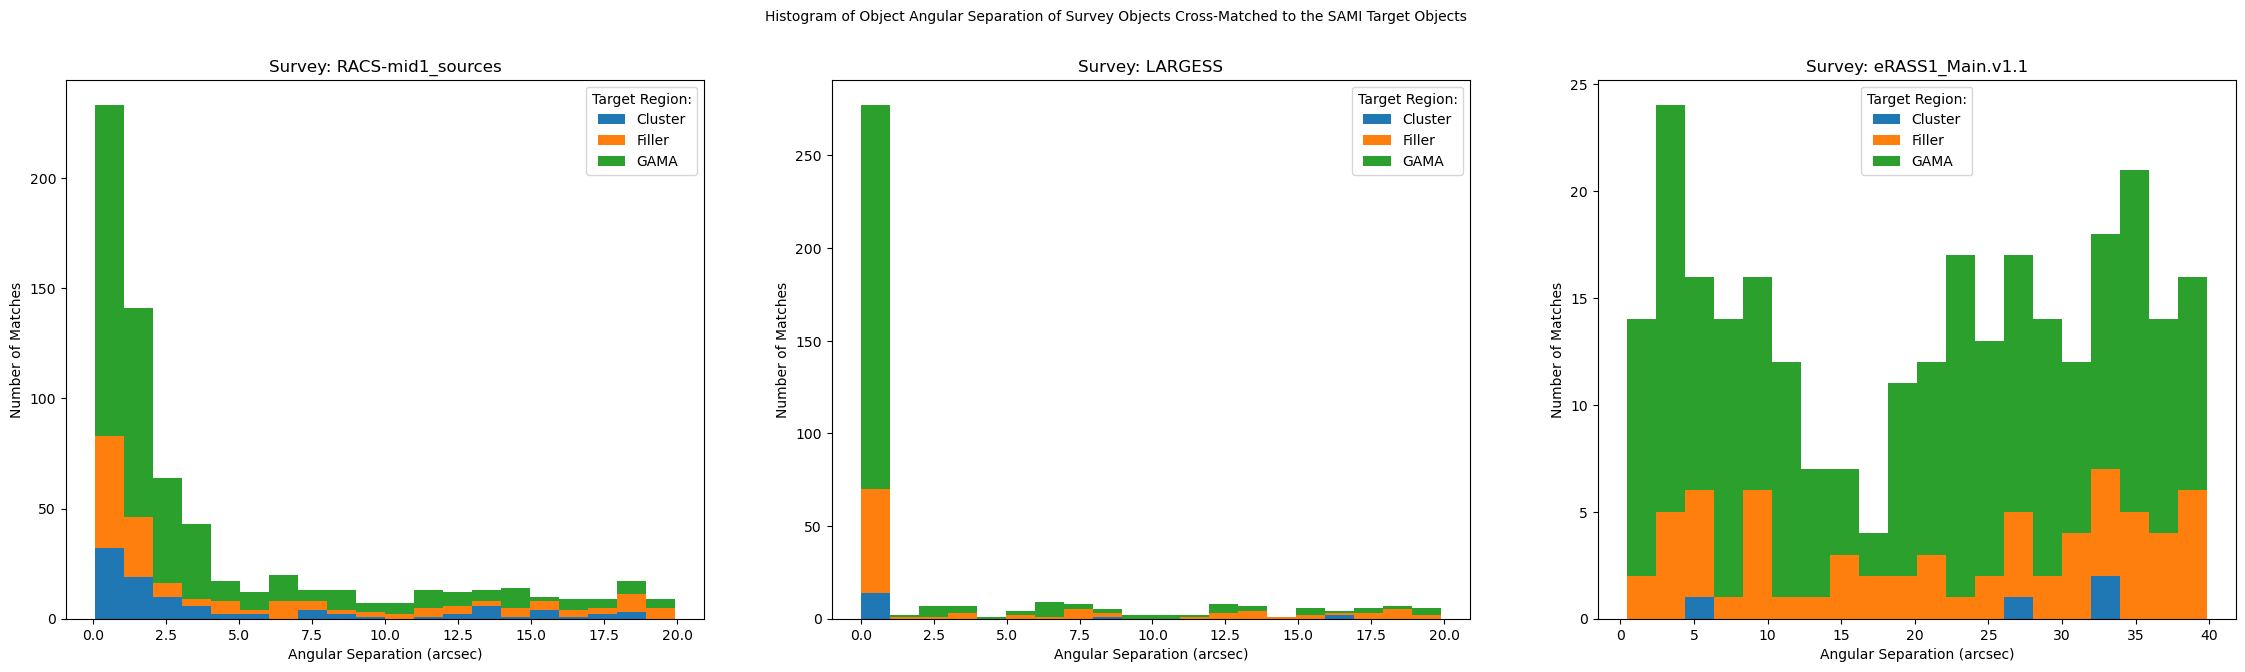

In [29]:
height, width = 7, 28
fig1, axs1 = plt.subplots(1, 3)
fig1.set_figheight(height)
fig1.set_figwidth(width)
fig1.suptitle(f'Histogram of Object Angular Separation of Survey Objects Cross-Matched to the SAMI Target Objects', fontsize=10)


for i, crossmatching_catalogue in enumerate(crossmatching_catalogues):    

    crossmatched_filename = f"all_SAMI_target_matched_{crossmatching_catalogue}"
    crossmatched_filepath = fits_filepath+"Crossmatched\\"+crossmatched_filename

    with fits.open(crossmatched_filepath) as crossmatched_hdul:
        crossmatched_table_hdu = Table(crossmatched_hdul[1].data)

        separation_array = np.array(crossmatched_table_hdu['separation'])
        region_ls = crossmatched_table_hdu['SAMI_region']
        sep_regions = [0,0,0]

    for j, region in enumerate(SAMI_regions):    
        region_separation_array = separation_array[region_ls==region]
        sep_regions[j] = region_separation_array


    ax = axs1.flatten()[i]
    nbins = 20
    ax.hist(sep_regions, bins = nbins, stacked=True, label=SAMI_regions)
    ax.set_title(f"Survey: {crossmatching_catalogue[:-5]}")
    ax.legend(title='Target Region:')
    ax.set_xlabel('Angular Separation (arcsec)')
    ax.set_ylabel('Number of Matches')


### healpy attempt

In [30]:
# import healpy as hp
# import numpy as np
# import matplotlib.pyplot as plt

# # Load a HEALPix map (replace with your survey data)
# nside = 128  # Resolution of the HEALPix map
# npix = hp.nside2npix(nside)
# survey_map = np.zeros(npix)  # Example: Empty map
# indices = np.random.choice(npix, 5000, replace=False)  # Random points in the survey
# survey_map[indices] = 1  # Mark observed regions

# # Plot in Mollweide projection
# hp.mollview(survey_map, title="Survey Coverage", cmap="Blues")
# plt.show()



# Random misalignment Plots

#### uniform distribution attempt

When generating random points to crossmatch to, probably not beneficial to just add a random number to every point as for RACS this will be >3e6 sources. Could instead maybe generate a random layout of the same number (as in the cutout of the RACS) in each region so same density. 


for each individual SAMI region:

    #get number of points in the region cutout of the survey
    num_points = len(get_RA_Dec_cutout_fits_table)

    # then generate random distribution dependent on region shape

    if GAMA:
    unif(lat_bounds), unif(long_bounds)

    if Cluster:
    spherically uniform


In [31]:

def get_unif_rand_points_in_region(num_points, bounds, region_type = 'rect', make_table=False):
    '''
    generates a uniformly random distribution of num_points points within a circular or rectangular region with bounds
    '''

    if region_type in ('rect', 'GAMA'):
        RA_array = np.random.uniform(bounds[0][0], bounds[1][0], size=num_points) %360 # to endure RA remains within [0, 360)
        Dec_array = np.random.uniform(bounds[0][1], bounds[1][1], size=num_points)
    
    elif region_type in ('circ', 'Cluster'):
        r_bound = bounds[1]
        theta = np.random.uniform(0,2*np.pi, num_points)
        radius = np.random.uniform(0,r_bound**2, num_points) **0.5

        RA_array = (bounds[0][0]+ radius * np.cos(theta) )
        Dec_array = bounds[0][1]+ radius * np.sin(theta)
        
    else:
        raise TypeError(f"Invalid bound type: {region_type}. Valid types are \'rect\' and \'circ\'")

    if make_table:

        return Table([RA_array, Dec_array], names=('RA', 'Dec'))
    else:
        return RA_array, Dec_array


def get_randomised_pos_table(catalogue_table, rand_lims=(0.1, 0.1), col_names = ('RA', 'Dec')):
    '''
    generates a randomly shifted catalogue\\
    rand_lims = (RA_shift, Dec_shift) in degrees
    '''

    rand_RA_shift = np.random.uniform(-rand_lims[0], rand_lims[0], size=len(catalogue_table))
    rand_Dec_shift = np.random.uniform(-rand_lims[1], rand_lims[1], size=len(catalogue_table))

    shifted_RA_array = catalogue_table[col_names[0]] + rand_RA_shift
    shifted_Dec_array = catalogue_table[col_names[1]] + rand_Dec_shift

    return Table([shifted_RA_array, shifted_Dec_array], names=('RA', 'Dec'))
    
    

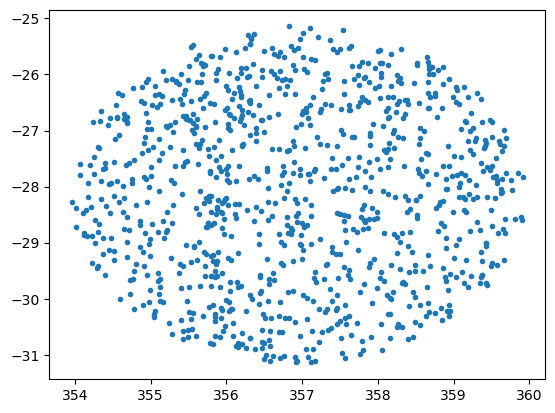

In [32]:
test = get_unif_rand_points_in_region(1000,  ((356.937810, -28.140661), 3), region_type='circ')
plt.plot(test[0], test[1], '.')

GAMA
GAMA
GAMA
Cluster
Cluster
Cluster
Cluster
Cluster
Cluster
Cluster
Cluster


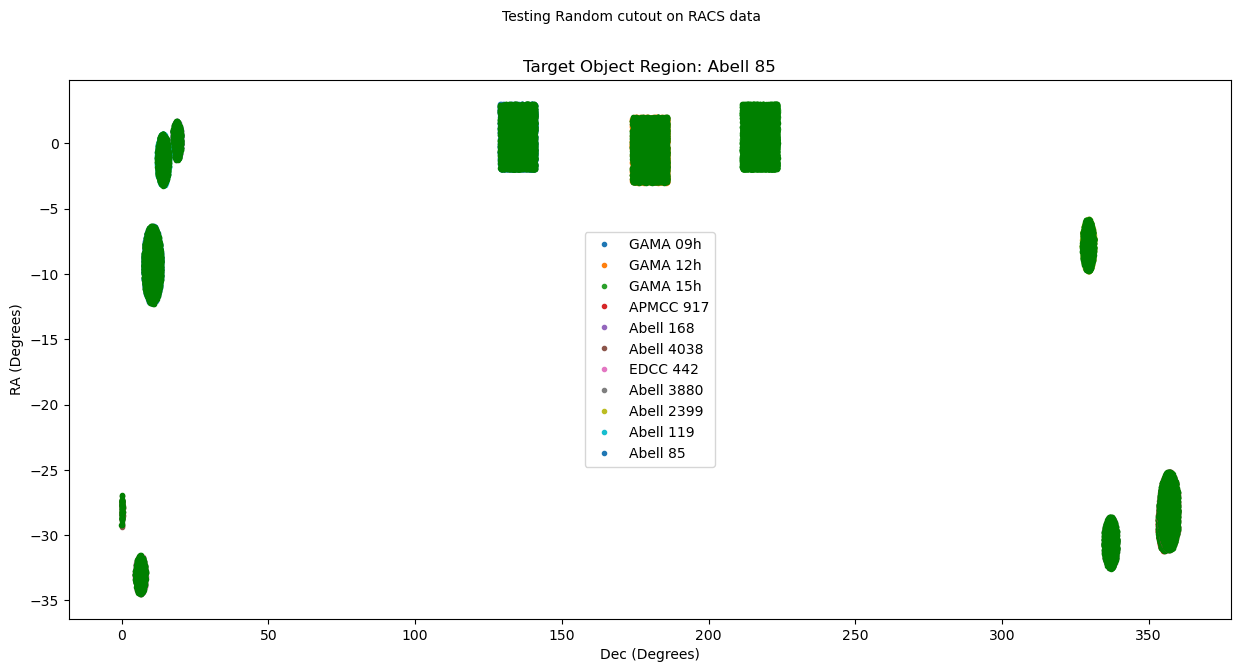

In [33]:
refresh_module()

crossmatching_colnames_dict = {'SAMI': ('RA_OBJ', 'DEC_OBJ'),
                               'RACS-mid1_sources.fits': ('RA', 'Dec'),
                               'LARGESS.fits': ("RAdeg", "DEdeg"),
                               'eRASS1_Main.v1.1.fits': ('RA', 'DEC')}

GAMA_region_bounds = [((129,-2), (141, 3)), ((174, -3), (186, 2)), ((211.5, -2), (223.5, 3))] # bounds of the GAMA target regions in the SAMI data including filler which are rectangular in shape (bottom left to top right coords) all in degrees
Cluster_region_bounds = [((355.397880, -29.236351), 2), ((18.815777, 0.213486), 1.5), ((18.739974, 0.430807), 1), 
                            ((356.937810, -28.140661), 3), ((6.380680, -33.046570), 1.5), ((336.977050, -30.575371), 2), 
                            ((329.372605, -7.795692), 2), ((14.067150, -1.255370), 2), ((10.460211, -9.303184), 3)] # bounds of the Cluster target regions (including filler targets) circular in shape  ((x_centre,y_centre), r_approx) all in degrees

SAMI_regions = ("Cluster", "Filler", "GAMA")

SAMI_regions_dict = {'GAMA 09h': ('GAMA', ((129,-2), (141, 3)) ),
                     'GAMA 12h': ('GAMA', ((174, -3), (186, 2)) ),
                     'GAMA 15h': ('GAMA', ((211.5, -2), (223.5, 3)) ),
                     'APMCC 917': ('Cluster', ((355.397880, -29.236351), 2) ),
                     'Abell 168': ('Cluster', ((18.815777, 0.213486), 1.5) ),
                     'Abell 4038': ('Cluster', ((356.937810, -28.140661), 3) ),
                     'EDCC 442': ('Cluster', ((6.380680, -33.046570), 1.5) ),
                     'Abell 3880': ('Cluster', ((336.977050, -30.575371), 2) ),
                     'Abell 2399': ('Cluster', ((329.372605, -7.795692), 2) ),
                     'Abell 119': ('Cluster', ((14.067150, -1.255370), 2) ),
                     'Abell 85': ('Cluster', ((10.460211, -9.303184), 3) )}


for i, crossmatching_catalogue in enumerate(crossmatching_catalogues[:1]):    
    height, width = 7, 15
    fig1, axs1 = plt.subplots(1, 1)
    fig1.set_figheight(height)
    fig1.set_figwidth(width)
    fig1.suptitle(f'Testing Random cutout on RACS data', fontsize=10)
    ax=axs1

    pos_col_names = crossmatching_colnames_dict[crossmatching_catalogue]

    # open catalogue
    with fits.open(Source_dir+"Catalogues\\"+crossmatching_catalogue) as catalogue_hdul:
        catalogue_table = Table(catalogue_hdul[1].data)

    for j, region in enumerate(SAMI_regions_dict.keys()):
        region_type, bounds = SAMI_regions_dict[region]
        print(region_type)
        
        cutout_table = all_fctns.get_RA_Dec_cutout_fits_table(catalogue_table, bounds, bound_type=region_type, col_names=pos_col_names)

        num_cutout_points = len(cutout_table)
        ax.plot(cutout_table[pos_col_names[0]], cutout_table[pos_col_names[1]], '.' ,label=region)

        # now get the random points
        rand_table = get_randomised_pos_table(catalogue_table, col_names = pos_col_names)

        rand_cutout_table = all_fctns.get_RA_Dec_cutout_fits_table(rand_table, bounds, bound_type=region_type, col_names=('RA', 'Dec'))
        ax.plot(rand_cutout_table['RA'], rand_cutout_table['Dec'], 'g.')
        
    ax.set_title(f"Target Object Region: {region}")
    ax.legend()
    ax.set_xlabel('Dec (Degrees)')
    ax.set_ylabel('RA (Degrees)')


## Monte-Carlo Separation plots

In [34]:
import all_fctns
def get_monte_carlo_separation_plot(catalogue_filepath, crossmatching_catalogue, crossmatching_colnames = ('RA', 'Dec'), max_sep_arcsec = 30, max_shifts = (0.1, 0.1), nbins=30, matching_sep=2, n_trials = 100):
    # test if a cutout of the survey exists
    try:
        with fits.open(catalogue_filepath + "SAMI_target_region_cutout_" + crossmatching_catalogue) as survey_cutout_hdul:
            None
    except FileNotFoundError: # if not, produce one
        print("SAMI Target Region Cutout does not already exist.")
        all_fctns.get_fits_table_SAMI_target_regions_cutout(catalogue_filepath, crossmatching_catalogue, col_names=crossmatching_colnames)


    with fits.open(catalogue_filepath + "ALL_SAMI_TARGETS.fits") as all_SAMI_targets_hdul, fits.open(catalogue_filepath + "SAMI_target_region_cutout_" + crossmatching_catalogue) as survey_cutout_hdul:
        all_SAMI_target_table = Table(all_SAMI_targets_hdul[1].data)
        survey_cutout_table_hdu = Table(survey_cutout_hdul[1].data)

    # # only need position cols (might help with run time)
    # all_SAMI_target_table.keep_columns(('RA_OBJ', 'DEC_OBJ'))
    # survey_cutout_table_hdu.keep_columns(crossmatching_colnames)


    real_matched_table = all_fctns.get_crossmatched_fits_table(catalogue_filepath, 
                                                    all_SAMI_target_table, 
                                                    survey_cutout_table_hdu,
                                                    sep_arcsec = max_sep_arcsec, 
                                                    crossmatching_colnames=crossmatching_colnames)
    real_separations = real_matched_table['sep_arcsec']

    # STEP 3: Generate a Monte Carlo (random-shifted) catalog
    all_random_separations = []
    num_random_matches = []

    for i in range(n_trials):
        # create a new table that we can shift
        shifted_survey_cutout_table = survey_cutout_table_hdu.copy()

        # Randomly shift catalogue RA and DEC with uniform distribution
        RA_shift = np.random.uniform(-max_shifts[0], max_shifts[0], size=len(shifted_survey_cutout_table))  # degrees
        Dec_shift = np.random.uniform(-max_shifts[1], max_shifts[1], size=len(shifted_survey_cutout_table))

        shifted_survey_cutout_table[crossmatching_colnames[0]] = ( survey_cutout_table_hdu[crossmatching_colnames[0]]  + RA_shift)%360
        shifted_survey_cutout_table[crossmatching_colnames[1]] = np.mod((survey_cutout_table_hdu[crossmatching_colnames[1]] + Dec_shift) +90, 180) -90
        
        # do crossmatching again with SAMI data
        rand_matched_table = real_matched_table = all_fctns.get_crossmatched_fits_table(catalogue_filepath, 
                                                    all_SAMI_target_table, 
                                                    shifted_survey_cutout_table,
                                                    sep_arcsec = max_sep_arcsec,
                                                    crossmatching_colnames=crossmatching_colnames)
        all_random_separations.append(real_matched_table['sep_arcsec'])
        num_random_matches.append(np.sum(real_matched_table['sep_arcsec']<=matching_sep))

    # Average histogram seperation plot
    bins = np.linspace(0, max_sep_arcsec, nbins)

    real_sep_hist, _ = np.histogram(real_separations, bins=bins)
    rand_sep_hist_avg = np.mean([np.histogram(seps, bins=bins)[0] for seps in all_random_separations], axis=0)


    bin_centers = 0.5 * (bins[1:] + bins[:-1])

    plt.plot(bin_centers, real_sep_hist, label="Real matches", color='black')
    plt.plot(bin_centers, rand_sep_hist_avg, label="Monte Carlo matches", color='red', linestyle='--')
    plt.xlabel("Separation (arcsec)")
    plt.ylabel("Number of matches")
    plt.legend()
    plt.title(f"Monte-Carlo Cross-matching Comparison for {crossmatching_catalogue[:-5]}")
    return all_random_separations, real_separations



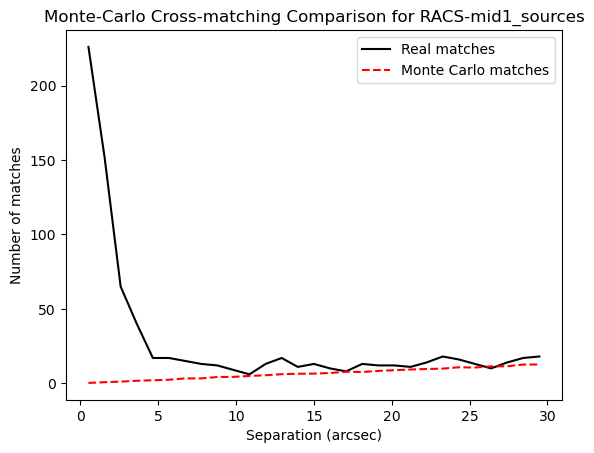

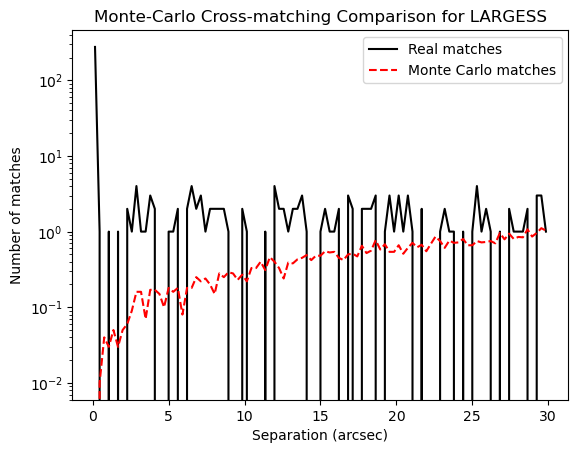

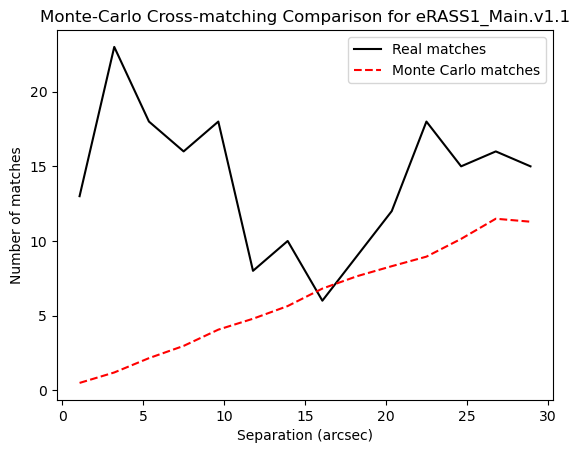

In [35]:
get_monte_carlo_separation_plot(Source_dir+"Catalogues\\", "RACS-mid1_sources.fits", crossmatching_colnames=('RA', 'Dec'), max_sep_arcsec=30, max_shifts=(0.1, 0.1))
plt.show()

get_monte_carlo_separation_plot(Source_dir+"Catalogues\\", "LARGESS.fits", crossmatching_colnames=('RAdeg', 'DEdeg'), nbins=100)
plt.yscale('log')
plt.show()

get_monte_carlo_separation_plot(Source_dir+"Catalogues\\", "eRASS1_Main.v1.1.fits", crossmatching_colnames=('RA', 'DEC'), nbins=15)
plt.show()

Cutout saved to C:\Users\mspan\OneDrive - The University of Sydney (Students)\Honours\Honours Project\Catalogues\SAMI_target_regions_cutout_LARGESS.fits


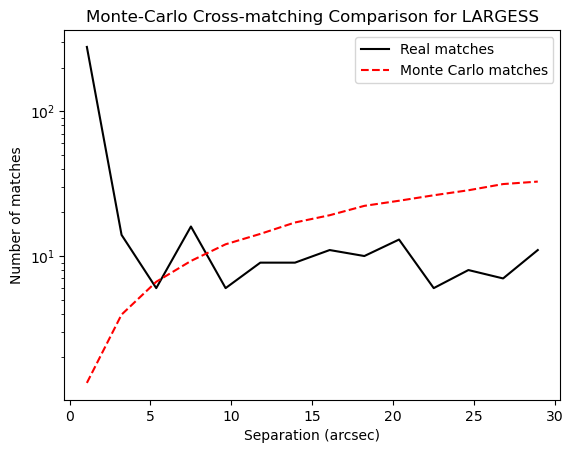

Genuine Matches: 279
Mean Random Matches: 1.1633333333333333
Reliability: 0.9958303464755077
Number of Missed Matches: 14.953333333333333
Completeness: 0.9491302474315652


In [ ]:
refresh_module()

# all_fctns.get_fits_table_SAMI_target_regions_cutout(Source_dir + "Catalogues\\", "LARGESS.fits", col_names=('RAdeg', 'DEdeg'), overwrite=True)

all_random_separations, real_separations = get_monte_carlo_separation_plot(Source_dir+"Catalogues\\", "LARGESS.fits", crossmatching_colnames=('RAdeg', 'DEdeg'), 
                                                                                         nbins=15, max_shifts=(0.01,0.01), n_trials=300)
plt.yscale('log')
plt.show()


def get_montecarlo_statistics(all_random_separations, real_separations, matching_sep, intercept_point):

    n_trials = len(all_random_separations)
    num_random_matches = np.zeros(n_trials)
    num_random_missed_points = np.zeros(n_trials)
    for i in range(len(all_random_separations)):
        num_random_matches[i] = np.sum(all_random_separations[i] <= matching_sep)
        num_random_missed_points[i] = np.sum((matching_sep<=all_random_separations[i]) & (all_random_separations[i] <= intercept_point))

    mean_num_random_matches = np.mean(num_random_matches)
    num_true_matches = np.sum(real_separations<=matching_sep)
    num_real_missed_points = np.sum((matching_sep<=real_separations) & (real_separations <= intercept_point))
    Reliability = 1-mean_num_random_matches/num_true_matches

    print(f"Genuine Matches: {num_true_matches}")
    print(f"Mean Random Matches: {mean_num_random_matches}")
    print(f"Reliability: {Reliability}")

    num_missed_matches = num_real_missed_points - np.mean(num_random_missed_points)
    print(f"Number of Missed Matches: {num_missed_matches}")
    print(f"Completeness: {num_true_matches /(num_missed_matches+num_true_matches)}")

get_montecarlo_statistics(all_random_separations, real_separations, matching_sep=2, intercept_point=7.5)





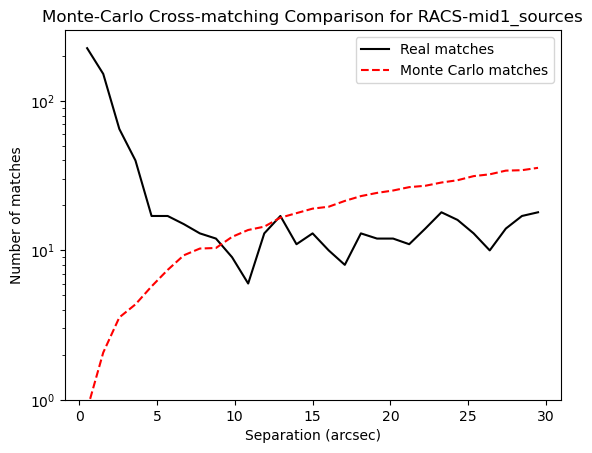

Genuine Matches: 497
Mean Random Matches: 15.47
Reliability: 0.9688732394366197
Number of Missed Matches: 23.840000000000003
Completeness: 0.9542277858843407


In [62]:
refresh_module()

# all_fctns.get_fits_table_SAMI_target_regions_cutout(Source_dir + "Catalogues\\", "RACS-mid1_sources.fits", col_names=('RA', 'Dec'), overwrite=True)

all_random_separations, real_separations  = get_monte_carlo_separation_plot(Source_dir+"Catalogues\\", "RACS-mid1_sources.fits", crossmatching_colnames=('RA', 'Dec'), 
                                                                                         max_sep_arcsec=30, max_shifts=(0.01, 0.01))
plt.yscale('log')
plt.ylim(1, plt.ylim()[1])
plt.show()

get_montecarlo_statistics(all_random_separations, real_separations, matching_sep=5, intercept_point=9)


[((355.39788, -29.236351), 3), ((18.815777, 0.213486), 2.5), ((18.739974, 0.430807), 2), ((356.93781, -28.140661), 4), ((6.38068, -33.04657), 2.5), ((336.97705, -30.575371), 3), ((329.372605, -7.795692), 3), ((14.06715, -1.25537), 3), ((10.460211, -9.303184), 4)]
